# Image Denoising

Suppose you are given a noisy image $f(x,y)$ and wish to find obtain a denoised image $u(x,y)$ that is as similar to the original image $f$. Mathematically, what we aim to find is 
$$\min_{
    \substack{u(x,y)}
} E(u(x,y)) = \iint_{\Omega} |\nabla u(x,y)| + \frac{\lambda}{2} \|u(x,y) - f(x,y)\|^2_2 \,dxdy$$
We want to find a new image $u$ that is similar to $f$ only with a small gradient (less rapid changes in adjacent pixel values, i.e. less noise). $\lambda$ is a user-defined parameter that decides the importance of each term.

To minimize $E$, we take its derivative and set it equal to $0$. However, because $E$ is a functional, we must use calculus of varitions to differentiate it. Doing so, we find that a stationary point for $E$ must satisfy the Euler-Lagrange Equation
$$\frac{\partial F}{\partial u} - \frac{\partial}{\partial x}\left(\frac{\partial F}{\partial u_x}\right) - \frac{\partial}{\partial y}\left(\frac{\partial F}{\partial u_y}\right) = 0$$
where $F = |\nabla u(x,y)| + \frac{\lambda}{2} \|u(x,y) - f(x,y)\|^2_2$.

Differentiating,
$$\frac{\partial F}{\partial u} = \lambda(u - f), \quad \frac{\partial F}{\partial u_x} = \frac{u_x}{\sqrt{u_x^2 + u_y^2}}, \quad \frac{\partial F}{\partial u_y} = \frac{u_y}{\sqrt{u_x^2 + u_y^2}}$$
and substituting in, we get
$$\begin{align*}
&\lambda(u - f) - \frac{\partial}{\partial x}\left(\frac{u_x}{\sqrt{u_x^2 + u_y^2}}\right) - \frac{\partial}{\partial y}\left(\frac{u_y}{\sqrt{u_x^2 + u_y^2}}\right) = 0, \\
\iff &\lambda(u - f) - \nabla \cdot \left(\frac{\nabla u}{|\nabla u|}\right) = 0
\end{align*}$$

This is a very diffcult PDE to solve analytically, so we will solve it numericlly using a finite discretization scheme combined with gradient descent.

For a grid spacing h = 1, the forward differences approximate the gradient:
$$
\begin{align*}
(u_x)_{i,j}^+ &= \frac{u_{i+1,j} - u_{i,j}}{h} \\
(u_y)_{i,j}^+ &= \frac{u_{i,j+1} - u_{i,j}}{h}
\end{align*}
$$

Similarly, the backward differences are:
$$
\begin{align*}
(u_x)_{i,j}^- &= \frac{u_{i,j} - u_{i-1,j}}{h} \\
(u_y)_{i,j}^- &= \frac{u_{i,j} - u_{i,j-1}}{h}
\end{align*}
$$

To avoid numerical instability when dividing by the gradient, we let $\nabla u = \nabla u + \epsilon$ and get that
$$|\nabla u|_{\epsilon} = \sqrt{u_x^2 + u_y^2 + \epsilon}$$

Discretizing the divergence term using central differences, we get that
$$
\text{div}\left(\frac{\nabla u}{|\nabla u|}\right) \approx \frac{1}{h}\left(\frac{(u_x)^+}{|\nabla u|_{\epsilon}^+} - \frac{(u_x)-}{|\nabla u|_{\epsilon}^-}\right) + \frac{1}{h}\left(\frac{(u_y)^+}{|\nabla u|_{\epsilon}^+} - \frac{(u_y)^-}{|\nabla u|_{\epsilon}^-}\right)
$$

The gradient descent update is then
$$u^{n+1} = u^n - \eta \left[\lambda(u^n - f) - \text{div}\left(\frac{\nabla u^n}{|\nabla u^n|}\right)\right]$$
where $\eta$ is the step size.

Note: In the implementation below, $h$ is assumed to be $1$ as most image formats store pixels as equally spaced gridpoints.

Loading image...
Loading image from ../img/panda.jpg
Initial load shape: (427, 640, 3), dtype: uint8
Final data shape: (427, 640, 3), dtype: float32
Image shape: (427, 640, 3)


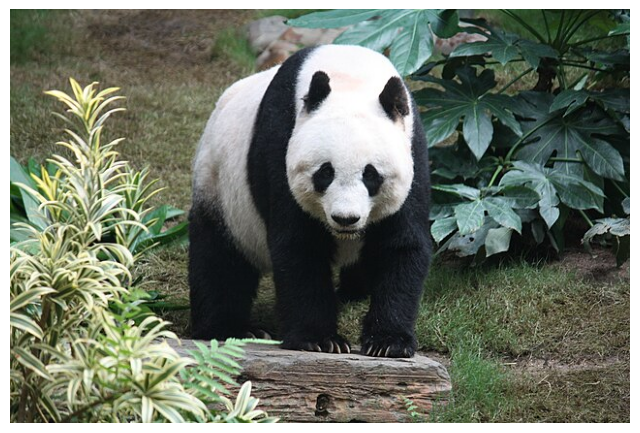


Adding noise...

Adding noise to image with shape: (427, 640, 3)
Noisy data shape: (427, 640, 3)
Array input shape: (427, 640, 3), dtype: float32
Final data shape: (427, 640, 3), dtype: float32
is_color check: shape=(427, 640, 3), result=True
is_grayscale check: shape=(427, 640, 3), result=False
Created noisy image: color=True, gray=False
Noisy image PSNR: 20.45 dB


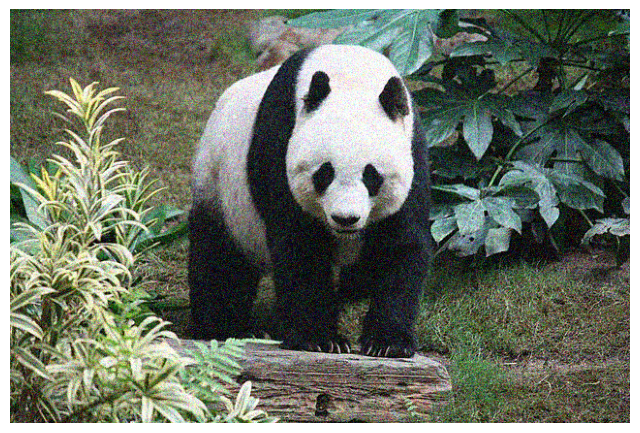


Denoising...
is_color check: shape=(427, 640, 3), result=True
is_color check: shape=(427, 640, 3), result=True
Array input shape: (427, 640, 3), dtype: float32
Final data shape: (427, 640, 3), dtype: float32
Denoised image PSNR: 20.08 dB


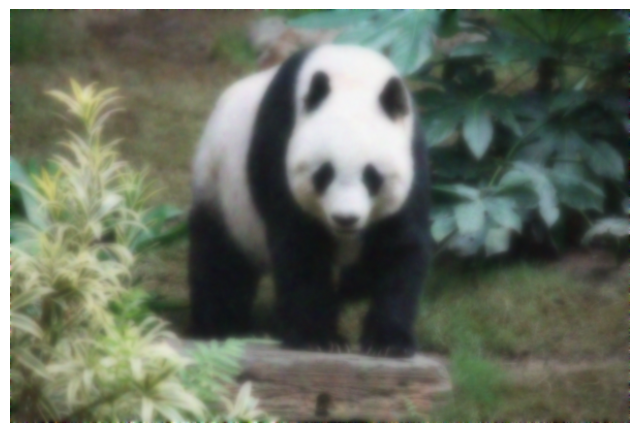

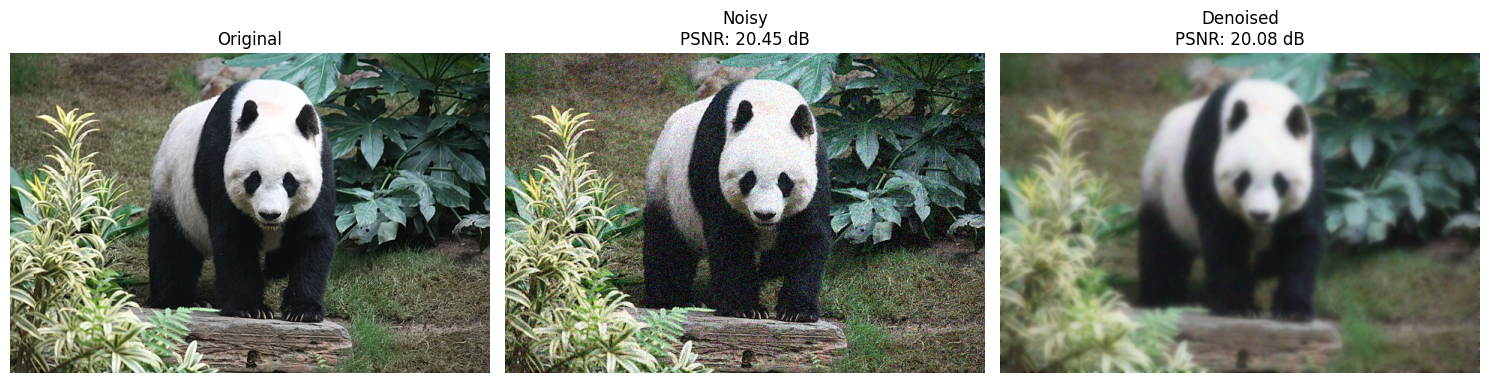

In [4]:
import numpy as np
from cv_lib import Image, NoiseGenerator, TVDenoiser, BoundaryCondition
import matplotlib.pyplot as plt
import numpy as np


def calculate_psnr(original, noisy):
    """Calculate Peak Signal-to-Noise Ratio."""
    mse = np.mean((original.data - noisy.data) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

# Load image
print("Loading image...")
img = Image("../img/panda.jpg")
print(f"Image shape: {img.shape}")
img.show()

# Add noise
print("\nAdding noise...")
noisy_img = NoiseGenerator.add_gaussian_noise(img, var=0.01)
noisy_psnr = calculate_psnr(img, noisy_img)
print(f"Noisy image PSNR: {noisy_psnr:.2f} dB")
noisy_img.show()

# Create and apply denoiser
print("\nDenoising...")
denoiser = TVDenoiser(
    mu=0.1,
    lambda_=0.1,
    gamma=1.0,
    max_iters=100,
    boundary_condition=BoundaryCondition.NEUMANN
)

denoised_img = denoiser.denoise(noisy_img)
denoised_psnr = calculate_psnr(img, denoised_img)
print(f"Denoised image PSNR: {denoised_psnr:.2f} dB")
denoised_img.show()

# Display all images side by side
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img.data)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(noisy_img.data)
axes[1].set_title(f'Noisy\nPSNR: {noisy_psnr:.2f} dB')
axes[1].axis('off')

axes[2].imshow(denoised_img.data)
axes[2].set_title(f'Denoised\nPSNR: {denoised_psnr:.2f} dB')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Loading image from ../img/panda.jpg
Initial load shape: (427, 640, 3), dtype: uint8
Final data shape: (427, 640, 3), dtype: float32

Adding noise to image with shape: (427, 640, 3)
Noisy data shape: (427, 640, 3)
Array input shape: (427, 640, 3), dtype: float32
Final data shape: (427, 640, 3), dtype: float32
is_color check: shape=(427, 640, 3), result=True
is_grayscale check: shape=(427, 640, 3), result=False
Created noisy image: color=True, gray=False

Adding noise to image with shape: (427, 640, 3)
Noisy data shape: (427, 640, 3)
Array input shape: (427, 640, 3), dtype: float32
Final data shape: (427, 640, 3), dtype: float32
is_color check: shape=(427, 640, 3), result=True
is_grayscale check: shape=(427, 640, 3), result=False
Created noisy image: color=True, gray=False

Adding noise to image with shape: (427, 640, 3)
Noisy data shape: (427, 640, 3)
Array input shape: (427, 640, 3), dtype: float32
Final data shape: (427, 640, 3), dtype: float32
is_color check: shape=(427, 640, 3), res

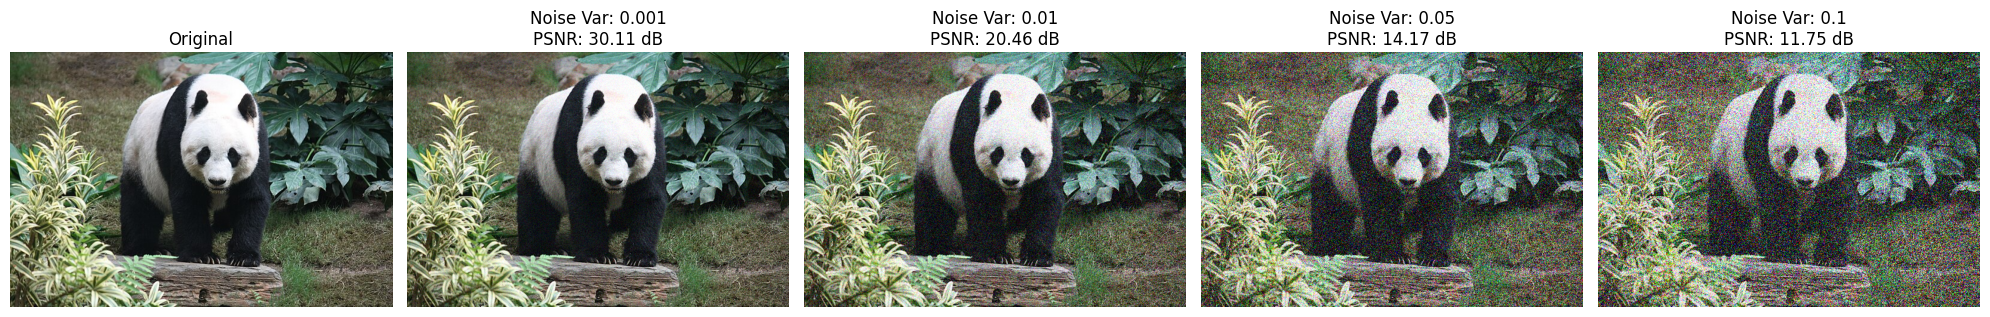

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from cv_lib import Image, NoiseGenerator

def calculate_psnr(original: Image, processed: Image, max_value: float = 1.0) -> float:
    """Calculate Peak Signal-to-Noise Ratio between two images.
    
    PSNR = 20 * log10(MAX) - 10 * log10(MSE)
    where MAX is the maximum possible pixel value (1.0 for float, 255 for uint8)
    and MSE is the mean squared error between the images.
    
    Higher PSNR values indicate better image quality:
    - >40 dB: Excellent quality (differences barely noticeable)
    - 30-40 dB: Good quality
    - 20-30 dB: Acceptable quality
    - <20 dB: Poor quality
    
    Parameters
    ----------
    original : Image
        Reference image
    processed : Image
        Modified image to compare against original
    max_value : float, optional
        Maximum possible pixel value, by default 1.0
        
    Returns
    -------
    float
        PSNR value in decibels (dB)
    """
    # Calculate Mean Squared Error
    mse = np.mean((original.data - processed.data) ** 2)
    
    if mse == 0:
        return float('inf')
    
    # Calculate PSNR
    psnr = 20 * np.log10(max_value) - 10 * np.log10(mse)
    return psnr

# Example showing PSNR with different noise levels
def demonstrate_psnr():
    # Load original image
    img = Image("../img/panda.jpg")
    
    # Create noisy versions with different variances
    noise_levels = [0.001, 0.01, 0.05, 0.1]
    noisy_images = []
    psnr_values = []
    
    for var in noise_levels:
        noisy = NoiseGenerator.add_gaussian_noise(img, var=var)
        noisy_images.append(noisy)
        psnr_values.append(calculate_psnr(img, noisy))
    
    # Display results
    fig, axes = plt.subplots(1, len(noise_levels) + 1, figsize=(20, 4))
    
    # Show original
    axes[0].imshow(img.data)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Show noisy versions
    for idx, (noisy, var, psnr) in enumerate(zip(noisy_images, noise_levels, psnr_values)):
        axes[idx + 1].imshow(noisy.data)
        axes[idx + 1].set_title(f'Noise Var: {var}\nPSNR: {psnr:.2f} dB')
        axes[idx + 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return psnr_values

# Run demonstration
psnr_values = demonstrate_psnr()